#### Bibliotecas

In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

#### Base de dados

In [66]:
df = pd.read_csv("../dados/plataforma.csv")

In [67]:
df.shape

(7, 27)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 27 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   platform                                          7 non-null      int64  
 1   water_depth                                       7 non-null      int64  
 2   weight                                            7 non-null      int64  
 3   installation_date                                 7 non-null      int64  
 4   type_of_production (1 oil and gas; 2 oil; 3 gas)  7 non-null      int64  
 5   number_of_legs                                    7 non-null      int64  
 6   number_of_piles                                   7 non-null      int64  
 7   height_of_jacket_or_sub-structure                 7 non-null      float64
 8   distance_to_coast                                 7 non-null      int64  
 9   risk_to_other_users-compl

In [69]:
platform_remove = ['platform']

In [70]:
df.drop(platform_remove, axis=1, inplace=True)

In [71]:
df.shape

(7, 26)

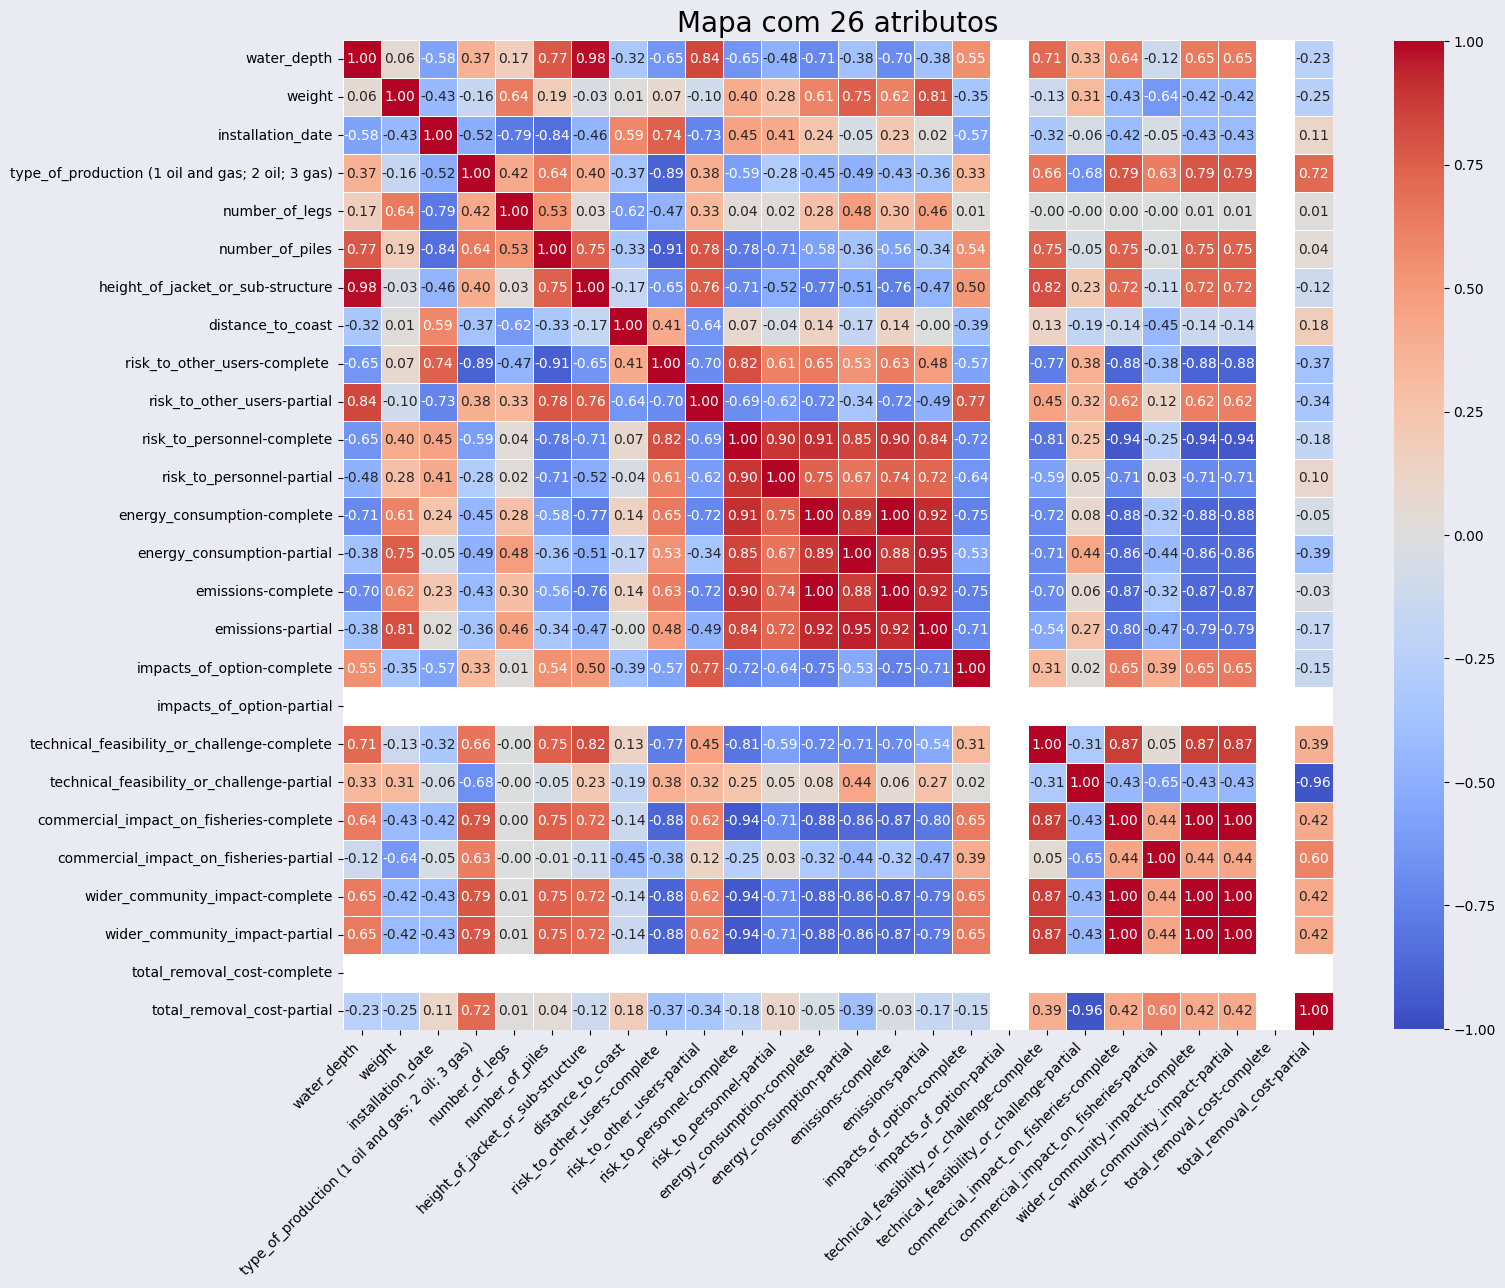

In [72]:
matriz_correlacao = df.corr()

plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685}
)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Mapa com 26 atributos', fontsize=20)

plt.tight_layout()

plt.show()

In [73]:
impacts_partial_and_cost_complete = df[['impacts_of_option-partial', 'total_removal_cost-complete']]

In [74]:
print(impacts_partial_and_cost_complete)

   impacts_of_option-partial  total_removal_cost-complete
0                          1                            1
1                          1                            1
2                          1                            1
3                          1                            1
4                          1                            1
5                          1                            1
6                          1                            1


In [75]:
df

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,impacts_of_option-complete,impacts_of_option-partial,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,99,22000,1988,1,8,8,114.0,187,1,0.000000e+00,...,0.43,1,0.00,1.00,0.79,0.78,0.50,0.50,1,0.56
1,112,30364,1983,1,8,9,123.0,207,1,0.000000e+00,...,0.51,1,0.00,1.00,0.79,0.78,0.50,0.50,1,0.56
2,141,15561,1978,2,8,26,147.0,120,0,2.500000e-05,...,0.66,1,0.25,1.00,1.00,0.94,1.00,1.00,1,0.53
3,156,27647,1980,2,8,32,166.0,240,0,1.500000e-05,...,0.53,1,0.64,1.00,1.00,0.66,1.00,1.00,1,0.57
4,103,18584,1983,3,8,20,122.5,230,0,7.800000e-08,...,0.53,1,0.39,0.15,1.00,0.99,1.00,1.00,1,0.73
5,144,17500,1983,3,8,20,154.0,130,0,1.335933e-05,...,0.53,1,0.45,0.70,1.00,1.00,1.00,1.00,1,0.66
6,116,10054,1993,1,4,5,136.0,282,1,0.000000e+00,...,0.53,1,0.29,0.81,0.93,0.86,0.83,0.83,1,0.60


In [76]:
remove_impacts_partial_and_cost_complete = ['impacts_of_option-partial', 'total_removal_cost-complete']

In [77]:
df.drop(remove_impacts_partial_and_cost_complete, axis=1, inplace=True)

In [78]:
df.shape

(7, 24)

#### Aplicação da GAN

##### Gerador

In [79]:
class Gerador(nn.Module):
    def __init__(self, tamanho_entrada, tamanho_saida):
        super(Gerador, self).__init__()
        
        # Definição da arquitetura do modelo
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, tamanho_saida), # Segunda camada de saída
            nn.Tanh() # Valores de saída no intervalo de (0 e 1)
        )

    def forward(self, x):
        return self.modelo(x)

##### Discriminador

In [80]:
class Discriminador(nn.Module):
    def __init__(self, tamanho_entrada):
        super(Discriminador, self).__init__()
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, 1),
            nn.Sigmoid() # Saídas em (0 e 1)
        )

    def forward(self, x):
        return self.modelo(x)

##### Treinando o discriminador

In [81]:
def treinar_discriminador(discriminador, otimizador, dados_reais, dados_falsos):
    otimizador.zero_grad() # Zera os gradientes
    previsao_real = discriminador(dados_reais) # Passando as 7 instâncias originais pro discriminador
    perda_real = criterio(previsao_real, torch.ones_like(previsao_real)) # Próximo de 1 = verdadeiro, próximo de 0 = falso
    perda_real.backward() # Algoritmo de backpropagation (Feed-Forward e Feed-Backward)

    previsao_falsa = discriminador(dados_falsos)
    perda_falsa = criterio(previsao_falsa, torch.zeros_like(previsao_falsa)) # Próximo de 0 = verdadeiro, próximo de 1 = falso
    perda_falsa.backward()

    otimizador.step() # Atualiza os gradientes

    return perda_real + perda_falsa

##### Treinando o gerador

In [82]:
def treinar_gerador(gerador, otimizador, dados_falsos): # Etapa de duelo entre o gerador e o discriminador
    otimizador.zero_grad()
    previsao = discriminador(dados_falsos) 
    perda = criterio(previsao, torch.ones_like(previsao))
    perda.backward()
    otimizador.step()
    return perda

##### Função de normalização

In [83]:
def normalizar(df): # Garante que os dados estejam no intervalo de (0 e 1)
    return (df - df.min()) / (df.max() - df.min())

##### Função de desnormalização

In [84]:
def desnormalizar(df, df_normalizado): # Retorna os valores ao original
    return df_normalizado * (df.max() - df.min()) + df.min()

##### Normalizando os dados

In [85]:
df_normalizado = normalizar(df)

##### Definindo dimensões

In [86]:
tamanho_entrada = len(df.columns)  # Aplica em todas as colunas da base de dados (24)
tamanho_saida = tamanho_entrada

##### Ajuste de hiperparâmetros

In [87]:
numero_epocas = 1000 # Quantidade de iterações em cima da base
tamanho_batch = 32 # Dados divididos em lotes

# Cálculo das iterações = numero_epocas * tamanho_batch

taxa_aprendizado = 0.001
quantidade_novos_registros = 1000

In [88]:
# Iniciando o gerador e o discriminador
gerador = Gerador(tamanho_entrada, tamanho_saida)
discriminador = Discriminador(tamanho_entrada)

In [89]:
# Definindo a função de perda
criterio = nn.BCELoss() # Entropia cruzada para casos binários

# Definindo os otimizadores
otimizador_gerador = optim.Adam(gerador.parameters(), lr=taxa_aprendizado) # Estava usando antes o (SGD)
otimizador_discriminador = optim.Adam(discriminador.parameters(), lr=taxa_aprendizado)

##### Treiinando a GAN

In [90]:
for epoca in range(numero_epocas):
    for i in range(0, len(df_normalizado), tamanho_batch):
        # Colocando os dados reais no formato que o PyTorch interpreta
        dados_reais = torch.tensor(df_normalizado.iloc[i:i+tamanho_batch].values, dtype=torch.float32)
        
        # Dados falsos feitos pelo Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)

        # Treinando o Discriminador
        perda_discriminador = treinar_discriminador(discriminador, otimizador_discriminador, dados_reais, dados_falsos)

        # Treinando o Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)
        perda_gerador = treinar_gerador(gerador, otimizador_gerador, dados_falsos)

    # Imprimir progresso a cada 100 épocas
    if (epoca+1) % 100 == 0:
        print(f"Época [{epoca+1}/{numero_epocas}], Perda do Discriminador: {perda_discriminador.item()}, Perda do Gerador: {perda_gerador.item()}")

Época [100/1000], Perda do Discriminador: 1.035841941833496, Perda do Gerador: 0.8894558548927307
Época [200/1000], Perda do Discriminador: 0.8354402780532837, Perda do Gerador: 1.230595350265503
Época [300/1000], Perda do Discriminador: 0.5932844877243042, Perda do Gerador: 1.6757383346557617
Época [400/1000], Perda do Discriminador: 0.6918790340423584, Perda do Gerador: 1.2137794494628906
Época [500/1000], Perda do Discriminador: 1.062793493270874, Perda do Gerador: 0.9518722295761108
Época [600/1000], Perda do Discriminador: 1.1401681900024414, Perda do Gerador: 0.7504503726959229
Época [700/1000], Perda do Discriminador: 1.2363369464874268, Perda do Gerador: 0.8933144807815552
Época [800/1000], Perda do Discriminador: 0.893447756767273, Perda do Gerador: 1.0845197439193726
Época [900/1000], Perda do Discriminador: 0.9493470191955566, Perda do Gerador: 1.0834790468215942
Época [1000/1000], Perda do Discriminador: 1.0138264894485474, Perda do Gerador: 0.9131596088409424


##### Gerando dados sintéticos e aplicando restrições

In [91]:
# Gerar dados sintéticos para toda a base de dados
novos_registros = []
for _ in range(quantidade_novos_registros // tamanho_batch):
    ruido = torch.randn(tamanho_batch, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()
    
    # Restrição 1: Valores negativos iguais a zero
    batch_sintetico[batch_sintetico < 0] = 0

    novos_registros.append(batch_sintetico)


# Quando o número de dados gerados não é múltiplo do tamanho do batch
dados_restantes = quantidade_novos_registros % tamanho_batch
if dados_restantes > 0:
    ruido = torch.randn(dados_restantes, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()
    
    # Restrição 1: Valores negativos iguais a zero
    batch_sintetico[batch_sintetico < 0] = 0

    novos_registros.append(batch_sintetico)

##### Desnormalizando e salvando

In [92]:
novos_registros = np.concatenate(novos_registros)
novos_registros = desnormalizar(df, pd.DataFrame(novos_registros, columns=df.columns))

In [93]:
novos_registros.to_csv('../dados/registros_gan.csv', index=False)

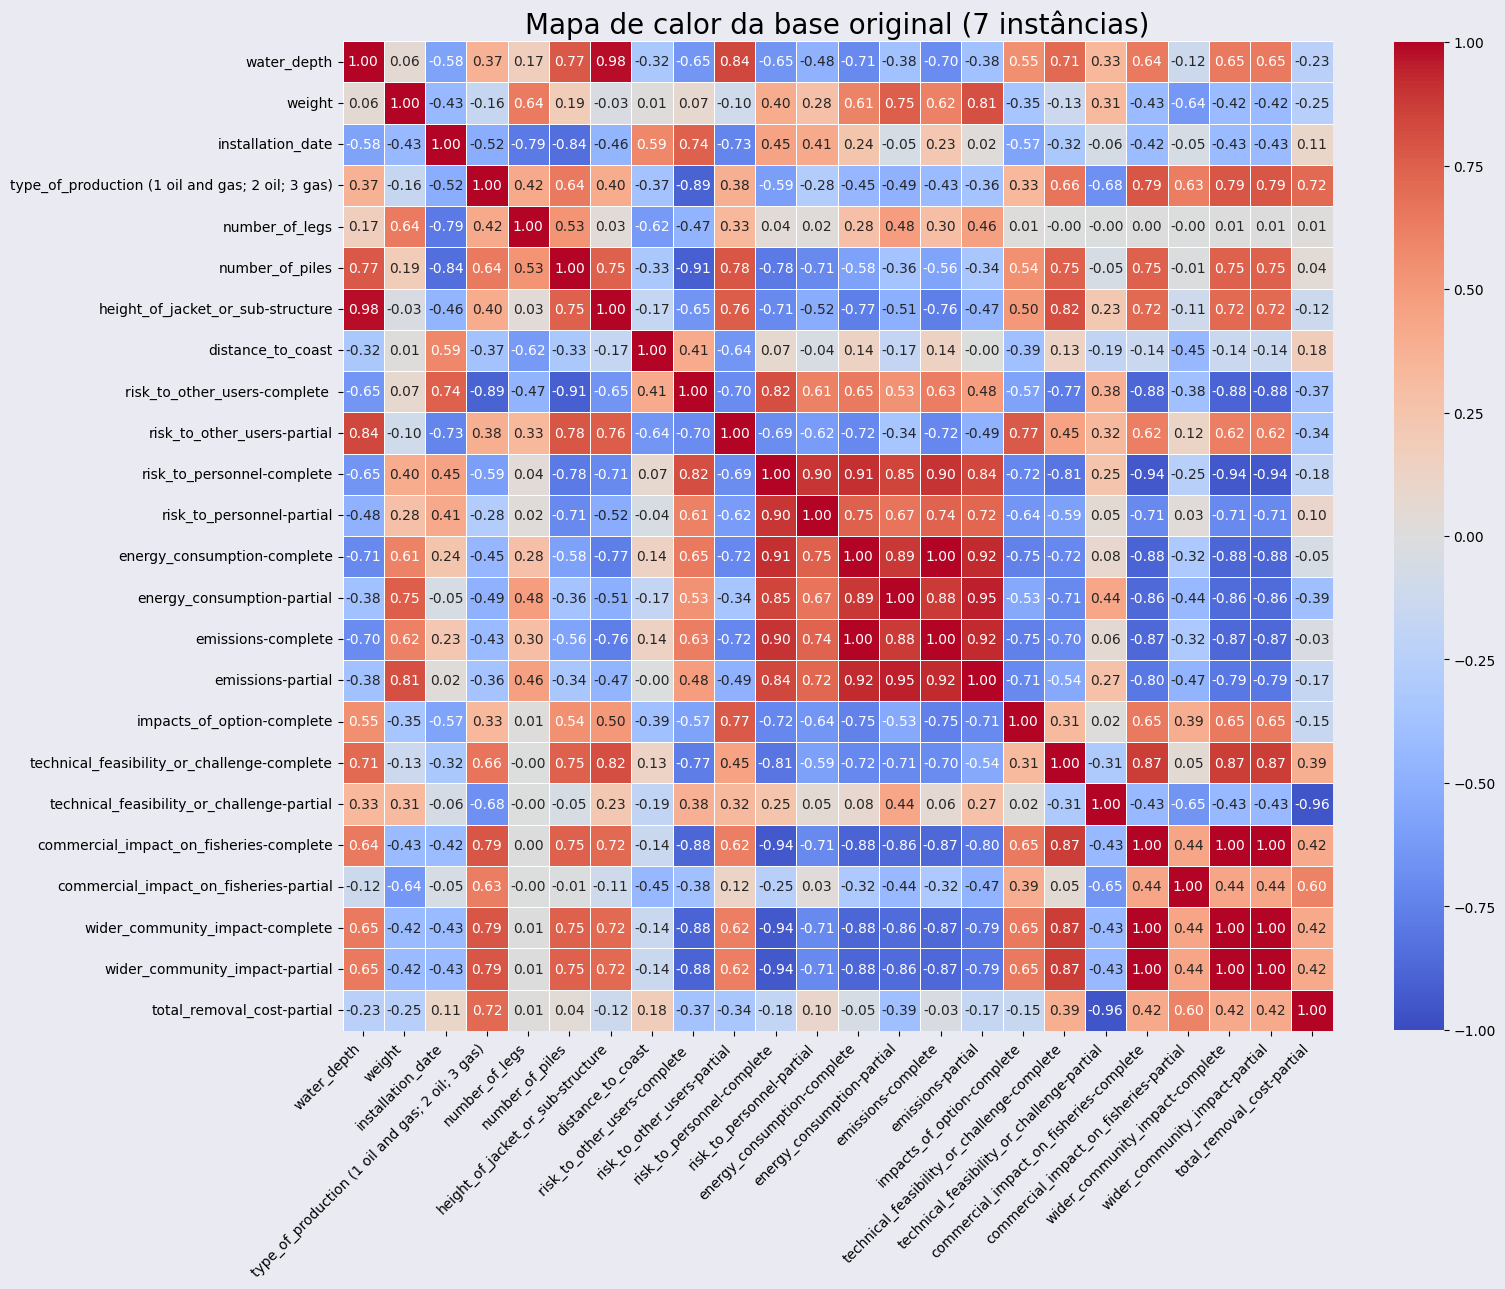

In [94]:
matriz_correlacao = df.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor da base original (7 instâncias)', fontsize=20)

plt.tight_layout()

plt.show()

In [95]:
df_gan = pd.read_csv("../dados/registros_gan.csv")

In [96]:
df_gan.shape

(1000, 24)

In [97]:
df_gan

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial
0,122.074514,25782.561459,1978.000000,1.929992,7.075463,12.178249,145.291900,123.492853,0.437724,0.000017,...,40473.000029,31064.000000,0.563343,0.499307,0.627615,0.975506,0.890186,0.958486,0.967679,0.584393
1,150.209545,27018.024752,1978.000000,2.862702,7.910525,24.318782,160.374923,120.000000,0.000000,0.000022,...,34519.029327,31064.000000,0.624100,0.609361,0.711186,0.999851,0.953687,0.999663,0.999563,0.613525
2,130.981178,21128.980190,1978.000000,2.370102,6.985720,12.588467,145.107805,132.263960,0.112234,0.000015,...,37884.879037,31064.000000,0.556253,0.438033,0.536670,0.983122,0.859840,0.977292,0.970383,0.565104
3,99.738868,26374.266449,1981.889355,1.000000,6.891533,5.000000,117.872771,120.000000,0.984771,0.000009,...,82242.770004,55599.468917,0.514751,0.250117,0.932289,0.790000,0.725072,0.500000,0.510141,0.547596
4,139.147246,23698.194192,1978.000000,2.507003,7.430907,17.592120,152.283167,121.260671,0.000000,0.000018,...,32060.476807,31064.000000,0.572138,0.506347,0.641398,0.996344,0.898274,0.993207,0.991529,0.580516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,133.737307,21623.081736,1978.000000,2.335653,7.133734,13.931763,143.637223,120.000000,0.009490,0.000015,...,31965.088291,31064.000000,0.553488,0.441313,0.553230,0.985879,0.865200,0.975406,0.968225,0.561436
996,125.681076,19810.552880,1978.000000,1.882982,6.365562,10.329844,136.966009,120.000000,0.037817,0.000010,...,29480.190362,32973.246991,0.522328,0.331803,0.503305,0.961838,0.801502,0.928813,0.904553,0.564613
997,128.528022,26200.570185,1978.000000,1.912092,7.271916,5.597350,140.524776,120.000000,0.711208,0.000016,...,62219.120503,39271.537874,0.568209,0.400490,0.806047,0.958532,0.853287,0.911502,0.907548,0.572930
998,131.395754,25750.856622,1978.000000,2.281739,7.191538,11.105453,149.618581,120.000000,0.131326,0.000019,...,30478.084618,31064.000000,0.581736,0.473803,0.557486,0.984739,0.888411,0.975023,0.978368,0.603926


In [98]:
df

,water_depth,weight,installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure,distance_to_coast,risk_to_other_users-complete,risk_to_other_users-partial,...,emissions-complete,emissions-partial,impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-partial
0,99,22000,1988,1,8,8,114.0,187,1,0.000000e+00,...,87000,58500,0.43,0.00,1.00,0.79,0.78,0.50,0.50,0.56
1,112,30364,1983,1,8,9,123.0,207,1,0.000000e+00,...,92000,64000,0.51,0.00,1.00,0.79,0.78,0.50,0.50,0.56
2,141,15561,1978,2,8,26,147.0,120,0,2.500000e-05,...,24277,31064,0.66,0.25,1.00,1.00,0.94,1.00,1.00,0.53
3,156,27647,1980,2,8,32,166.0,240,0,1.500000e-05,...,40416,45266,0.53,0.64,1.00,1.00,0.66,1.00,1.00,0.57
4,103,18584,1983,3,8,20,122.5,230,0,7.800000e-08,...,59588,41170,0.53,0.39,0.15,1.00,0.99,1.00,1.00,0.73
5,144,17500,1983,3,8,20,154.0,130,0,1.335933e-05,...,42000,44000,0.53,0.45,0.70,1.00,1.00,1.00,1.00,0.66
6,116,10054,1993,1,4,5,136.0,282,1,0.000000e+00,...,37162,32191,0.53,0.29,0.81,0.93,0.86,0.83,0.83,0.60


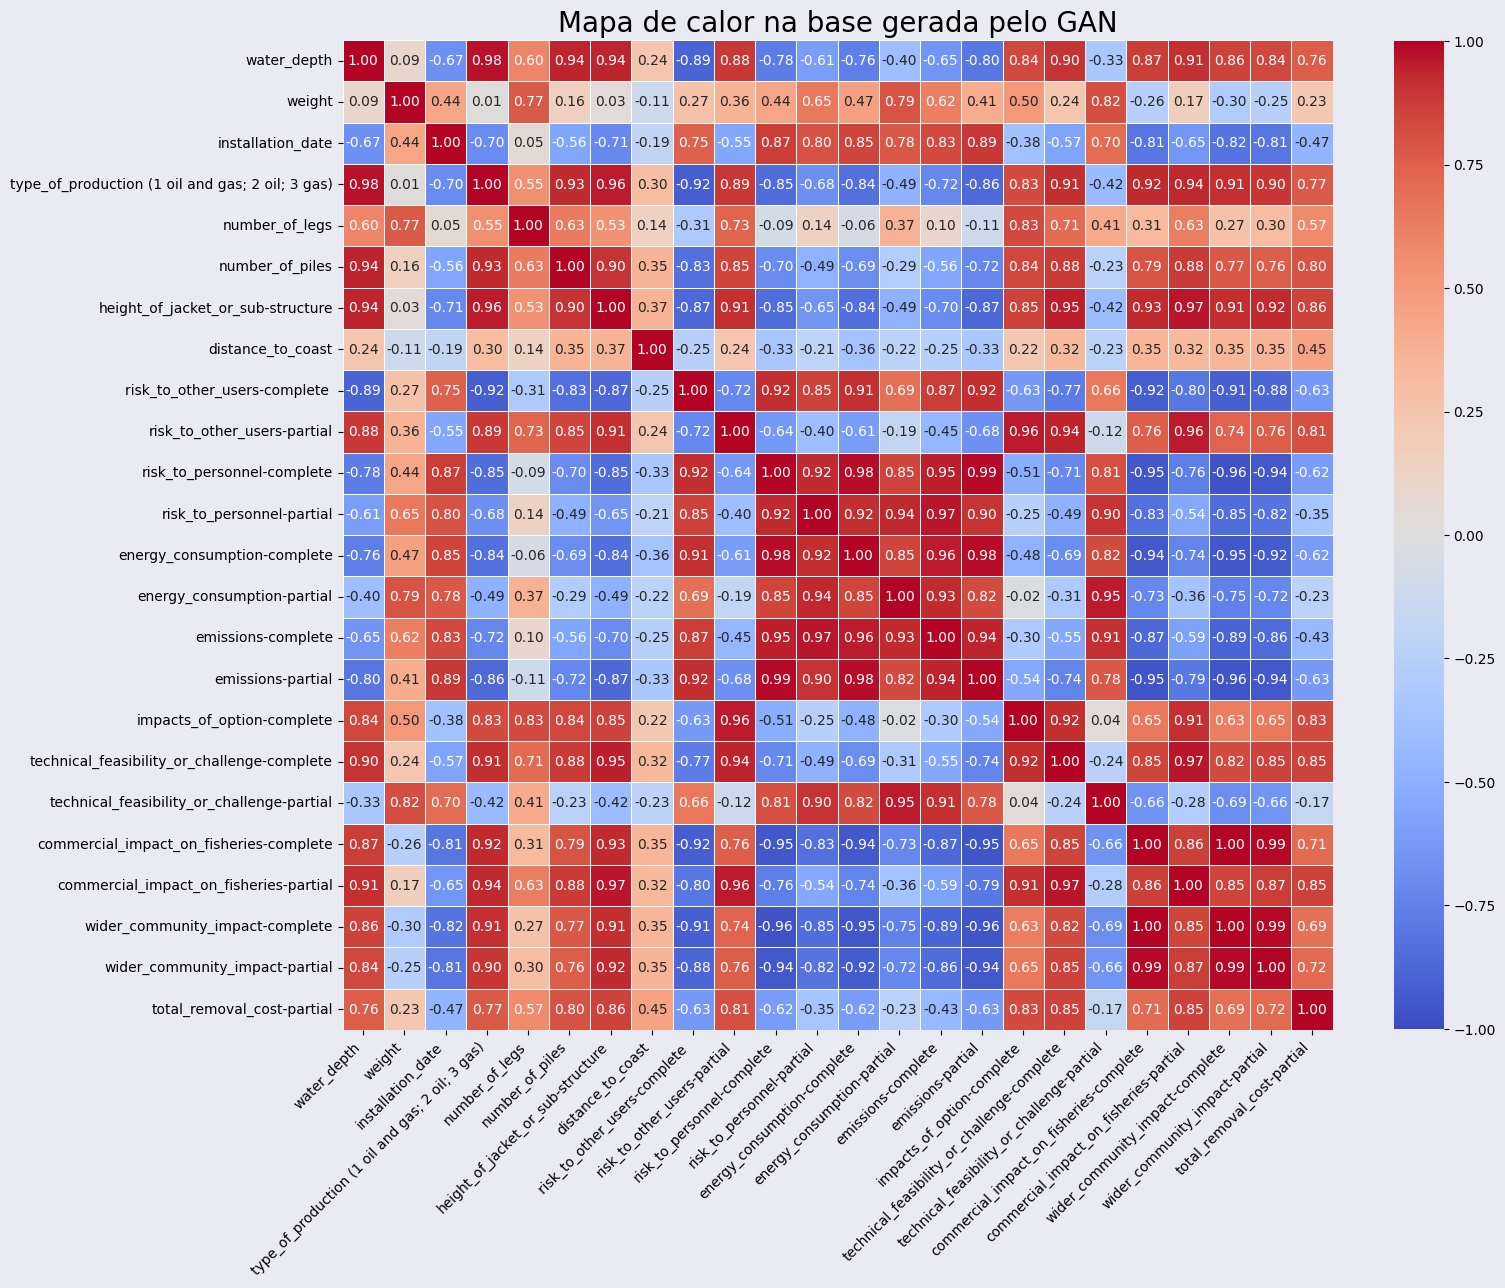

In [99]:
matriz_correlacao_gan = df_gan.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao_gan,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor na base gerada pelo GAN', fontsize=20)

plt.tight_layout()

plt.show()